# Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Check if CUDA (GPU) is available and set the device accordingly.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# For some reason, using the GPU is much slower than CPU
device = 'cpu'

# Data Loading

In [2]:
# Set up the label encoder for consistency in target labels
le = LabelEncoder()
labels = ['Benign', 'DDoS', 'Reconnaissance', 'Brute Force', 'password', 'xss', 'Backdoor']
le.fit(labels)

LabelEncoder()

In [3]:
class NFUQNIDS(Dataset):
    def __init__(self, attacks, use_synthetic):
        self.data = pd.DataFrame()

        for attack in attacks:
            temp = pd.read_csv(f'data/reduced/attacks/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}.csv')
            if self.data.empty:
                self.data = temp.copy()
            else:
                self.data = pd.concat([self.data, temp], ignore_index=True)

        if use_synthetic:
            for attack in attacks:
                if os.path.exists(f'data/synthetic/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}-SYNTHETIC.csv'):
                    temp = pd.read_csv(f'data/synthetic/NF-UQ-NIDS-ATTACKS-{str.upper(attack)}-SYNTHETIC.csv')
                    if self.data.empty:
                        self.data = temp.copy()
                    else:
                        self.data = pd.concat([self.data, temp], ignore_index=True)

        # Attack type as target label
        self.labels = self.data['Attack']
        self.labels = le.transform(self.labels)

        self.data.drop({'Attack', 'Label'}, axis=1, inplace=True, errors='ignore')

        self.data = self.data.values

        print(self.data)
        print(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx], dtype=torch.float32, device=device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32, device=device)
        label = label.type(torch.LongTensor).to(device)

        return features, label

In [4]:
# Real attack data
real_attack_data = NFUQNIDS({'DDoS', 'Reconnaissance', 'Brute Force', 'Password', 'XSS', 'Backdoor'}, use_synthetic=False)

train_size = int(0.9 * len(real_attack_data))
val_size = len(real_attack_data) - train_size
real_train_dataset, real_val_dataset = torch.utils.data.random_split(real_attack_data, [train_size, val_size])

# Synthetic attack data
synth_attack_data = NFUQNIDS({'DDoS', 'Reconnaissance', 'Brute Force', 'Password', 'XSS', 'Backdoor'}, use_synthetic=True)

train_size = int(0.9 * len(synth_attack_data))
val_size = len(synth_attack_data) - train_size
synth_train_dataset, synth_val_dataset = torch.utils.data.random_split(synth_attack_data, [train_size, val_size])

[[5.7966e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [5.8024e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [3.3420e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 ...
 [6.4202e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [6.0902e+04 8.0000e+01 6.0000e+00 ... 1.0000e+00 1.0000e+00 0.0000e+00]
 [4.5930e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[5 5 5 ... 3 3 3]
[[5.7966e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [5.8024e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [3.3420e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 ...
 [5.1281e+04 8.0000e+01 1.7000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.1372e+04 8.0800e+03 1.7000e+01 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [5.1281e+04 0.0000e+00 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]]
[5 5 5 ... 0 0 0]


In [5]:
batch_size = 4096

real_train = DataLoader(real_train_dataset, batch_size=batch_size, shuffle=True)
real_val = DataLoader(real_val_dataset, batch_size=batch_size, shuffle=True)

synth_train = DataLoader(synth_train_dataset, batch_size=batch_size, shuffle=True)
synth_val = DataLoader(synth_val_dataset, batch_size=batch_size, shuffle=True)

del real_train_dataset
del real_val_dataset
del synth_train_dataset
del synth_val_dataset

# Model Definition

In [6]:
# Model hyperparameters
input_dim = 74
hidden_dim = input_dim*2
num_classes = len(labels)

# Model definition
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

In [7]:
# Train the synthetic model
synth_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(synth_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
synth_train_loss_list = []
synth_val_loss_list = []
synth_real_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0
    cumulative_real_loss = 0

    for inputs, labels in synth_train:
        # Calculate training output and loss
        train_outputs = synth_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(synth_train))
    synth_train_loss_list.append(cumulative_train_loss)

    synth_model.eval()
    with torch.no_grad():
        for inputs, labels in synth_val:
            # Calculate training output and loss
            val_outputs = synth_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss

        for inputs, labels in real_val:
            # Calculate training output and loss
            real_outputs = synth_model(inputs)
            real_loss = criterion(real_outputs, labels)

        cumulative_real_loss = cumulative_real_loss + real_loss
    

    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(synth_val))
    synth_val_loss_list.append(cumulative_val_loss)

    # Calculate real loss this epoch
    cumulative_real_loss = cumulative_real_loss.item() / (len(real_val))
    synth_real_loss_list.append(cumulative_real_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}, Real Loss: {(cumulative_real_loss):.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [01:03<09:32,  6.36s/it]

Epoch [10/100], Train Loss: 353.9636, Validation Loss: 42.1130, Real Loss: 51.8657


 20%|██        | 20/100 [02:06<08:23,  6.30s/it]

Epoch [20/100], Train Loss: 162.6217, Validation Loss: 24.1594, Real Loss: 39.8650


 30%|███       | 30/100 [03:09<07:20,  6.29s/it]

Epoch [30/100], Train Loss: 56.2691, Validation Loss: 11.2332, Real Loss: 8.1701


 40%|████      | 40/100 [04:13<06:21,  6.36s/it]

Epoch [40/100], Train Loss: 74.4997, Validation Loss: 5.3823, Real Loss: 12.8628


 50%|█████     | 50/100 [05:15<05:12,  6.25s/it]

Epoch [50/100], Train Loss: 20.3512, Validation Loss: 1.1083, Real Loss: 0.9343


 60%|██████    | 60/100 [06:18<04:11,  6.29s/it]

Epoch [60/100], Train Loss: 26.1173, Validation Loss: 1.9456, Real Loss: 3.5575


 70%|███████   | 70/100 [07:21<03:09,  6.31s/it]

Epoch [70/100], Train Loss: 14.5428, Validation Loss: 3.1104, Real Loss: 3.0819


 80%|████████  | 80/100 [08:24<02:06,  6.32s/it]

Epoch [80/100], Train Loss: 11.0639, Validation Loss: 2.0445, Real Loss: 1.9552


 90%|█████████ | 90/100 [09:27<01:02,  6.29s/it]

Epoch [90/100], Train Loss: 12.1711, Validation Loss: 1.5692, Real Loss: 1.5821


100%|██████████| 100/100 [10:30<00:00,  6.31s/it]

Epoch [100/100], Train Loss: 0.7778, Validation Loss: 0.1592, Real Loss: 0.2684


In [8]:
# Train the real model
real_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(real_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
real_train_loss_list = []
real_val_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0

    for inputs, labels in real_train:
        # Calculate training output and loss
        train_outputs = real_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(real_train))
    real_train_loss_list.append(cumulative_train_loss)

    real_model.eval()
    with torch.no_grad():
        for inputs, labels in real_val:
            # Calculate training output and loss
            val_outputs = real_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss
        
    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(real_val))
    real_val_loss_list.append(cumulative_val_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}')

 10%|█         | 10/100 [00:52<07:48,  5.21s/it]

Epoch [10/100], Train Loss: 458.2023, Validation Loss: 91.4345


 20%|██        | 20/100 [01:44<06:57,  5.22s/it]

Epoch [20/100], Train Loss: 177.7819, Validation Loss: 37.9252


 30%|███       | 30/100 [02:36<06:06,  5.23s/it]

Epoch [30/100], Train Loss: 71.1822, Validation Loss: 4.7174


 40%|████      | 40/100 [03:28<05:12,  5.21s/it]

Epoch [40/100], Train Loss: 38.0775, Validation Loss: 1.6922


 50%|█████     | 50/100 [04:21<04:21,  5.23s/it]

Epoch [50/100], Train Loss: 34.0620, Validation Loss: 10.3923


 60%|██████    | 60/100 [05:13<03:28,  5.21s/it]

Epoch [60/100], Train Loss: 5.5462, Validation Loss: 1.7653


 70%|███████   | 70/100 [06:05<02:35,  5.18s/it]

Epoch [70/100], Train Loss: 1.9355, Validation Loss: 0.4831


 80%|████████  | 80/100 [06:57<01:44,  5.22s/it]

Epoch [80/100], Train Loss: 4.0424, Validation Loss: 0.4833


 90%|█████████ | 90/100 [07:49<00:52,  5.21s/it]

Epoch [90/100], Train Loss: 1.0110, Validation Loss: 0.1387


100%|██████████| 100/100 [08:41<00:00,  5.22s/it]

Epoch [100/100], Train Loss: 5.3638, Validation Loss: 0.7503


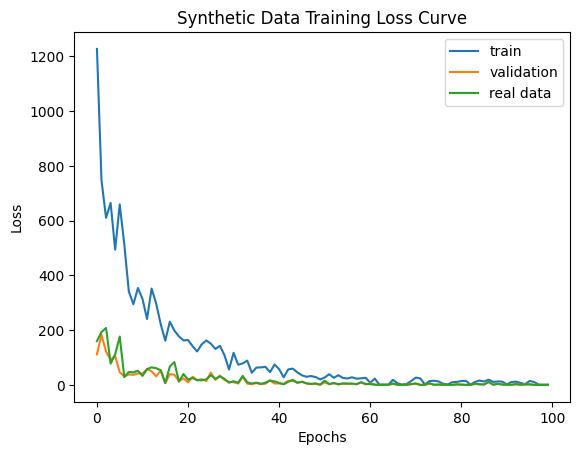

In [9]:
# Plot the synthetic loss curve
plt.plot(synth_train_loss_list, label="train")
plt.plot(synth_val_loss_list, label="validation")
plt.plot(synth_real_loss_list, label="real data")
plt.title("Synthetic Data Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

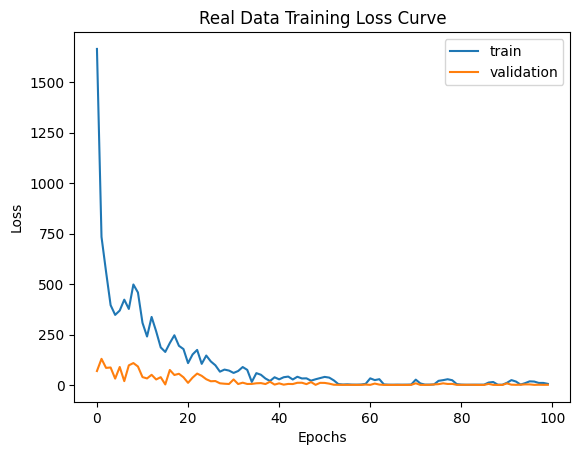

In [10]:
# Plot the real loss curve
plt.plot(real_train_loss_list, label="train")
plt.plot(real_val_loss_list, label="validation")
plt.title("Real Data Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
# Save the models
torch.save(synth_model.state_dict, 'models/synth_attack_classifier')
torch.save(real_model.state_dict, 'models/real_attack_classifier')

# Model Evaluation

In [12]:
# Evaluation
synth_model.eval()
real_model.eval()
with torch.no_grad():
    synth_metric = MulticlassAccuracy(num_classes=num_classes)
    real_metric = MulticlassAccuracy(num_classes=num_classes)
    synth_accuracy = 0
    real_accuracy = 0
    num = 0

    for inputs, labels in real_val:
        # Synth
        synth_outputs = synth_model(inputs)
        _, predicted = torch.max(synth_outputs, 1)
        synth_metric.update(predicted, labels)
        synth_accuracy = synth_accuracy + synth_metric.compute()

        # Real
        real_outputs = real_model(inputs)
        _, predicted = torch.max(real_outputs, 1)
        real_metric.update(predicted, labels)
        real_accuracy = real_accuracy + real_metric.compute()

        num = num + 1

    synth_accuracy = synth_accuracy / num
    real_accuracy = real_accuracy / num

    print(f"Synthetic model accuracy: {synth_accuracy}")
    print(f"Real model accuracy: {real_accuracy}")

Synthetic model accuracy: 0.8719357252120972
Real model accuracy: 0.8282850980758667
